## Information Bottleneck measure

Code for information bottleneck calculation and generating Figure 8 in: 

Glaze CM, Filipowicz ALS, Kable JW, Balasubramanian V, and Gold JI, "A bias-variance trade-off governs individual differences in on-line learning in an unpredictable environment"

In [8]:
#DEPENDENCIES FOR THE CODE THAT FOLLOWS
%pylab
%matplotlib inline
%qtconsole
import scipy,scipy.optimize,glob
from scipy import stats
import scipy.io as sio
from scipy.stats import spearmanr
import numpy as np
from numba import jit

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1) Predictive information function

This function calculates the predictive information between an array of participant responses and the array of stimulus features the participnt observed. The "Ipast" value is the one used in the predictive information/information bottleneck complexity analyses found in the manuscript.

In [2]:
@jit
def I_RF(resp,feat,resplen,featlen,numrespsymbols,numfeatsymbols):
    
    '''Function to calculate predictive information I(R;F) between responses R and stimulus features F
        Arguments:
            resp - array of participant responses on each trial
            feat - array of stimulus features on each trial
            resplen - word length for the responses (integer value) - set to 3 in current paper
            featlen - word length for the features (integer value) - set to 1 in current paper
            numrespsymbols - number of unique response values - set to 2 in the current paper (L/R responses)
            numfeatsymbols - number of unique feature values - set to 6 in the current paper (number of feature/hazard combinations)
    '''
    
    #Number of unique words that can be made given the participant responses/features window lengths
    numrespwords = numrespsymbols**resplen
    numfeatwords = numfeatsymbols**featlen
    
    #CALCULATE PROBABILITY DISTRIBUTIONS REQUIRED FOR MUTUAL INFORMATION CALCULATION
    
    #Bases used to index the different distributions
    aux_base_resp = numrespsymbols**np.arange(resplen)
    aux_base_feat = numfeatsymbols**np.arange(featlen)
    
    #Initialize response, feature, and joint distributions
    presp = np.zeros(numrespwords) #P(R)
    pfeat = np.zeros(numfeatwords) #P(F)
    prespfeat = np.zeros(numfeatwords*numrespwords) #P(R,F) - for Ifuture
    pfeatresp = np.zeros(numrespwords*numfeatwords) #P(F,R) - for Ipast   
    
    #Count frequences of response words occuring for P(R)
    for i in range(len(resp)-(resplen-1)):
        r = resp[i:i+resplen] #Response 'word' based on the desired response word length
        presp[int(sum(np.flip(r,0)*aux_base_resp))] += 1 #Add a count to the index that corresponds to the response word
    
    #Count frequencies of feature words occuring for P(F)
    for i in range(len(feat)-(featlen-1)):
        f = feat[i:i+featlen] #Feature 'word' based on the desired feature word length
        pfeat[int(sum(np.flip(f,0)*aux_base_feat))] += 1 #Add a count to the index that corresponds to the feature word
    
    #Count frequencies of response/feature joint distribution for P(R,F) (Ifuture)
    for i in range(len(feat)-(featlen+resplen-1)):
        r = resp[i:i+resplen] #Response 'word' based on the desired response word length
        f = feat[i+resplen:i+resplen+featlen] #Feature 'word' that follows the response word
        #Count the response/feature conjunctions
        prespfeat[int((sum(np.flip(r,0)*aux_base_resp)*numfeatwords)+sum(np.flip(f,0)*aux_base_feat))] += 1
        
    #Count frequencies of feature/response joint distribution for P(F,R) (Ipast)
    for i in range(len(resp)-(resplen+featlen-1)):
        f = feat[i:i+featlen] #Feature 'word' based on the desired feature word length
        r = resp[i+featlen:i+featlen+resplen] #Response 'word' that follows the feature word
        #Count the feature/response conjunctions
        pfeatresp[int((sum(np.flip(f,0)*aux_base_feat)*numrespwords)+sum(np.flip(r,0)*aux_base_resp))] += 1

    #Convert counts to probability distributions
    presp = presp/sum(presp) #P(R) marginal distribution
    pfeat = pfeat/sum(pfeat) #P(F) marginal distribution
    prespfeat = prespfeat/sum(prespfeat) #P(R,F) joint distribution
    pfeatresp = pfeatresp/sum(pfeatresp) #P(F,R) joint distribution
    
    #CALCULATE IPAST AND IFUTURE
    Ipast = 0
    Ifuture = 0
    for fi in range(len(pfeat)):
        pf = pfeat[fi] #P(F = f)
        for ri in range(len(presp)):
            pr = presp[ri] #P(R = r)
            
            #To calculate Ipast
            if pf > 0. and pfeatresp[(fi*numrespwords)+ri] > 0. and pr > 0.:
                pfr = pfeatresp[(fi*numrespwords)+ri]/pf #P(f|r) = P(f,r)/p(f)
                Ipast += pf*(pfr*log2(pfr/pr))
            
            #To calculate Ifuture
            if pf> 0. and prespfeat[(ri*numfeatwords)+fi] > 0. and pf > 0.:
                prf = prespfeat[(ri*numfeatwords)+fi]/pf #P(r|f) = P(r,f)/p(f)
                Ifuture += pf*(prf*log2(prf/pr))
                
    return Ipast,Ifuture

### 2) Import participant data

The code below extracts participant responses from their matlab structures and imports them into python arrays. These arrays are used for the predictive information/information bottleneck calculations that follow. 

**NOTE: To run this chunk of code, you will need to add local paths to the folder containing all raw participant data, and the paths to the parameter fits for the adaptivity and sampling models.**

In [7]:
# IMPORT AND EXTRACT RAW PARTICIPANT PERFORMANCE DATA

# Set your path to the the 'data' folder containing the raw performance data - e.g., '/Users/username/pathtodatafile/data/'
raw_data_path = #Set path to data directory
data_dir = glob.glob(raw_data_path+'data*.mat') #List of all data files within the specified path

#Matrices with subject information - the 12000 value corresponds to the maximum number of trials participants performed 
subs = []                                   #Order if subject identifiers for the raw data
h = np.zeros((len(data_dir),12000))         #trial-by-trial objective hazard rate values
obsx = np.zeros((len(data_dir),12000))      #trial-by-trial continuous star x positions
obsx_bin = np.zeros((len(data_dir),12000))  #binary coding for star x position (0 for left, 1 for right of center)
resp = np.zeros((len(data_dir),12000))      #trial-by-trial particiapnt response

#Markers for subjects who did not finish task - any row with -1s should be excluded
h[h==0] = -1
obsx[obsx==0] = -1
obsx_bin[obsx_bin == 0] = -1
resp[resp==0] = -1

#Extract raw data from all subject data files in the data directory
for i in range(len(data_dir)):
    #Load subject data
    sub_dat = sio.loadmat(data_dir[i])
    
    #Get subject identifiers
    subject = data_dir[i][-8:-4]
    if (subject[0] == '_'):
        subject = data_dir[i][-7:-4]
    elif (subject[1] == '_'):
        subject = data_dir[i][-6:-4]
    subs.append(subject)
    
    #Get data frame - subjects had up to 6 sessions of 2000 trials (max 12000 trials)
    startind = 0 #trial index
    datFiles = ['data1','data2','data3','data4','data5','data6'] #session names
    for dat in range(len(datFiles)):
        try:
            data = sub_dat[datFiles[dat]]
            #Extract and record participant data and trial inforamtion
            h[i,startind:startind+2000]=np.array(map(lambda(x):round(x[0],2),data['H'][0][0])) #Trial by trial hazard rates
            obsx[i,startind:startind+2000] = np.array(map(lambda(x):x[0],data['X'][0][0]))     #Star X position
            resp[i,startind:startind+2000] = np.array(map(lambda(x):x[0],data['pred'][0][0]))  #Particpant responses
            startind += 2000
        except:
            pass
    
#Convert continuous star x positions to binary variable
obsx_bin[(obsx > -1) & (obsx < 49.5)] = 0 #any star left of center is identified as 0
obsx_bin[(obsx >= 49.5)] = 1 #stars falling right of center identified as 1
    
#Convert responses identifiers to 0s and 1s
resp[resp == 1] = 0
resp[resp == 2] = 1


#IMPORT AND EXTRACT MODEL FITS FOR EACH SUBJECT
#Load structures with parameter values - to run, change the two paths below to adaptivity fits and particle filter filts respectively
reg_mod_path = #enter path to file 'allparam_fixedvarfits_regression.mat'
part_filt20_path = #enter path to file 'allparam_fixedvarfits_partfilt_sigma_partMfixed20.mat'

reg_fits = sio.loadmat(reg_mod_path)
part_filt20 = sio.loadmat(part_filt20_path)


#EXTRACT ADAPTIVITY MODEL PARAMETERS
subs2 = np.array(map(lambda(x):str(x[0][0]),reg_fits['subjids'])) #Order of subject IDs from the adaptivity model
regress_params = reg_fits['paramstrct_regress'] #Matrix of adaptivity parameters

#Extract H_default, H_m, and choice variability parameter values
reg_missing = [] #List of participants for whom regression values are missing
H0 = np.repeat(-1.,len(subs2))  #H_default
Hm = np.repeat(-1.,len(subs2))  #H_m
var = np.repeat(-1.,len(subs2)) #Variability
for i in range(len(H0)):
    try:
        H0[i] = 1/(1+np.exp(-1.*regress_params['params'][0][i][0][0])) #H_default
        Hm[i] = regress_params['params'][0][i][0][1]                   #H_m
        var[i] = regress_params['params'][0][i][0][2]                  #Variability
    except:
        #Keep track of any subjects missing fit values
        reg_missing.append(subs2[i])

        
        
#EXTRACT PARAMETERS FROM BEST FITTING SAMPLING MODEL (M = 20)
subs3 = np.array(map(lambda(x):str(x[0][0]),part_filt20['subjids'])) #Order of subject IDs from the particle filter model
part_filt20_params = part_filt20['paramstrct_sigma_partMfixed'] #Matrix of particle filter parameters

#Prior mean, prior width, and logK
pf_missing = []  #Subjects for whome particle filter parameters are missing
pm20 = np.repeat(-1.,len(subs3))  #Prior Mean
pw20 = np.repeat(-1.,len(subs3))  #Prior Precision
lK20 = np.repeat(-1.,len(subs3))  #LogK
for i in range(len(H0)):
    try:
        pm20[i] = part_filt20_params['params'][0][i][6][0] #Prior mean
        pw20[i] = part_filt20_params['params'][0][i][5][0] #Prior precision
        lK20[i] = part_filt20_params['params'][0][i][7][0] #LogK
    except:
        #Keep track of any subjects missing fit values
        pf_missing.append(subs3[i])


# MATCH INDEXING OF RAW PERFORMANCE DATA AND PARAMETER FITS
H0_ind = np.repeat(-1.,len(subs))   #Default adaptivity value
Hm_ind = np.repeat(-1.,len(subs))   #Adaptivity slope
var_ind = np.repeat(-1.,len(subs))  #Decision variability (slope of the psychometric function)
pm20_ind = np.repeat(-1.,len(subs)) #Prior mean from the best fitting sampling model
pw20_ind = np.repeat(-1.,len(subs)) #Prior width from the best fitting sampling model

#The loop below matches subject IDs between the raw data and model parameter arrays
#Any participants for whom parameter values are missing are labeled as -1.
subs2 = list(subs2)
subs3 = list(subs3)
subMissing = []
for i in range(len(subs)):
    try:
        s2_ind = subs2.index(subs[i])
        s3_ind = subs3.index(subs[i])
        if subs2[s2_ind] != subs3[s3_ind]:
            print "Indexing Error! Participants do not match"
        H0_ind[i] = H0[s2_ind]
        Hm_ind[i] = Hm[s2_ind]
        var_ind[i] = var[s2_ind]
        pm20_ind[i] = pm20[s3_ind]
        pw20_ind[i] = pw20[s3_ind]
        lK20_ind[i] = lK20[s3_ind]
    except:
        #Keep track of any subjects for whom we have raw data but no fit values
        subMissing.append(subs[i])

SyntaxError: invalid syntax (<ipython-input-7-df01b4fe77fa>, line 4)

### 3) Calculate predictive information

The code below converts stimulus position/hazard combinations into features that are used in the predictive information calculation, then calculates the predictive information for each subject. The 'Ipast' value from the predictive information calculation is used as a measure of a subject's mental model complexity. This calculation is done in three steps:

* 1) Calculate the predictive information between participant responses and stimulus features
* 2) Calculate the predictive information of the stimulus features alone
* 3) Subtract the stimulus predictive information from the participant's predictive information

In [4]:
# CONVERT OBSERVED STIMULI INTO X-POSITION/HAZARD FEATURE COMBINATIONS
# NOTE: The code below takes about 1 minute to run on a 2013 Macbook Pro

#Get list of x position/hazard rate features
featuresx = np.zeros((len(data_dir),12000))
featuresx[featuresx == 0] = -1.

#Screen center for this task - used to define stimulus features
center = [49.5,27.] #x,y center of the screen

#Six features - low,medium,high hazard when star is on the left, and same on the right
featuresx[(obsx_bin == 0) & (h <.33)] = 0.            #Left Low 
featuresx[(obsx_bin == 0) & (h >=.33) & (h<.66)] = 1. #Left Medium
featuresx[(obsx_bin == 0) & (h >=.66)] = 2.           #Left high

featuresx[(obsx_bin == 1) & (h <.33)] = 3.            #Right Low 
featuresx[(obsx_bin == 1) & (h >=.33)&(h<.66)] = 4.   #Right Medium
featuresx[(obsx_bin == 1) & (h >=.66)] = 5.           #Right high

#Arrays of subject ipasts and ifutures using windows of length 3
ips = np.repeat(-1.,len(subs))
ifs = np.repeat(-1.,len(subs))

#Arrays of bound calculated with x position of trial stimuli
xbips = np.repeat(-1.,len(subs))
xbifs = np.repeat(-1.,len(subs))

print "CALCULATING PREDICTIVE INFORMATION"
for i in range(len(subs)):
    x = obsx[i]            #Star x position for all trials observed by subject i
    x = x[x != -1]         #Remove any values that don't correspond to actual trials
    if len(x) > 0 : #This condition removes data from any participants that didn't start the task
        
        #Responses
        r = resp[i]
        r = r[r != -1]
        
        #Binary coded x star positions
        xb = obsx_bin[i]
        xb = xb[xb != -1]

        #Features 
        f = featuresx[i]
        f = f[f != -1]
            
        #Calculate subject Ipast and Ifuture with response window = 3 (step 1 above)
        ips[i],ifs[i] = I_RF(r,f,3,1,2,6)
        
        #Calculate the predictive information contained within the stimuli themselves (step 2 above)
        xbips[i],xbifs[i] = I_RF(xb,f,3,1,2,6)
        
#Calculate difference between subject predictive info and the stimulus information (step 3 above)
ipsxb = ips-xbips
ifsxb = ifs-xbifs

#Only keep the values for the participants that were fit by the adaptivity and sampling models
ipsxb = ipsxb[Hm_ind != -1]  
ifsxb = ifsxb[Hm_ind != -1]

print "DONE"

CALCULATING PREDICTIVE INFORMATION
DONE


### 4) Calculate and plot correlation between predictive information and model fit parameters

The code below calculates the correlations between the predictive information complexity measure and the model parameters from the adaptivity and sampling models, and produces the scatter plots used for Figure 8.

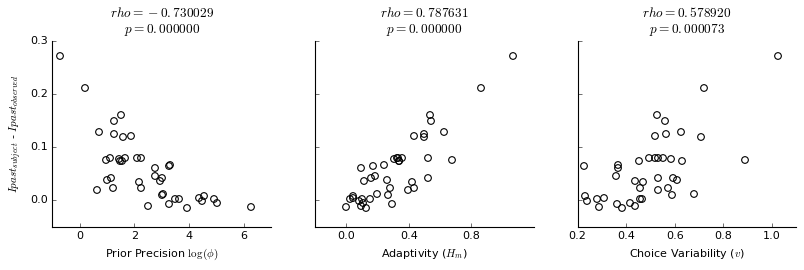

In [5]:
#Arrays of parameter values for participants that were fit by both the adaptivity and sampling models
hm = Hm_ind[Hm_ind != -1]     #Hm - adaptivity parameter
pw = pw20_ind[pw20_ind != -1] #Prior precision - sampling model parameter
v = var_ind[var_ind != -1]    #Choice Variability


#PLOT CORRELATIONS
figure(1,figsize=(12,3))

#Predictive information (Ipast) vs Prior Precision
ax1 = subplot(131)
plot(pw,ipsxb,'o',markerfacecolor='none',markeredgecolor='k',markeredgewidth=1)
#plot(np.unique(pw), np.poly1d(np.polyfit(pw, ipsxb, 1))(np.unique(pw)),'--k')
xlabel('Prior Precision $\log(\phi)$')
ylabel('$Ipast_{subject}$ - $Ipast_{observed}$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
yticks(np.array([0,.1,.2,.3]))
xticks(np.array([0,2,4,6]))

#Spearman correlation - Predictive information and Prior Precision
r,p = spearmanr(pw,ipsxb)
title('$rho = %f$\n$p=%f$'%(r,p))

#Predictive information (Ipast) vs Adaptivity
ax2 = subplot(132)
plot(hm,ipsxb,'o',markerfacecolor='none',markeredgecolor='k',markeredgewidth=1)
#plot(np.unique(hm), np.poly1d(np.polyfit(hm, ipsxb, 1))(np.unique(hm)),'--k')
xlabel('Adaptivity ($H_m$)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_yticklabels([])
yticks(np.array([0,.1,.2,.3]))
xticks(np.array([0,.4,.8]))

#Spearman correlation - Predictive information and Adaptivity
r,p = spearmanr(hm,ipsxb)
title('$rho = %f$\n$p=%f$'%(r,p))

#Predictive information (Ipast) vs Choice Variability
ax3 = subplot(133)
plot(v,ipsxb,'o',markerfacecolor='none',markeredgecolor='k',markeredgewidth=1)
xlabel('Choice Variability ($v$)')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_yticklabels([])
yticks(np.array([0,.1,.2,.3]))
xticks(np.array([0.2,.4,.6,.8,1.0]))

#Spearman correlation - Predictive information and Choice Variability
r,p = spearmanr(v,ipsxb)
title('$rho = %f$\n$p=%f$'%(r,p))